In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import sys
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv, AssignmentEnv, GameEnv
import pickle
from shortcut import multi_types
import numpy as np
import matplotlib.pyplot as plt
import collections

from shortcut import multi_types
from GameLearning import LRI, GameLearning, EXP3
from SA_baseline import recuit
from a_star import A_Star
from greedy_baseline import baseline, greedy

np.random.seed(42)

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def DP(env : RemoveActionEnv, excess, log = False):
    
    rtes = np.array([
        [
            env._env.initial_routes[m, i] 
            for i in range(0, len(env._env.initial_routes[m]), 2)
        ]
        for m in range(len(env._env.initial_routes))
    ], dtype=int)


    # print(env._env.distance_matrix)
    # print(CM)
    coeff = env._env._game.emissions_KM
    # CM = np.array([
    #     env._env.distance_matrix*coeff[i]
    #     for i in range(len(coeff))
    # ]).copy()
    a = multi_types(env._env.distance_matrix, rtes, coeff, excess)


    _, r, *_, info = env.step(a)
    
    if log:
        print(env.destinations)
        print(env._env.distance_matrix)
    info['rtes'] = rtes
    return a, r, info

def SA(env, log = False):
    
    if log:
        print(env.destinations)
        print(env._env.distance_matrix)
    T_init = 5_000
    T_limit = 1
    lamb = 0.9999
    T = 100_000

    action_SA, *_ = recuit(deepcopy(env._env), T_init, T_limit, lamb, H=T)
            # res = recuit_multiple(game, T_init = T_init, T_limit = T_limit, lamb = lamb, log=log, H=T)
    a = np.where(action_SA == 0)[0]

    # CM = np.array([
    #     env._env.distance_matrix*coeff[i]
    #     for i in range(len(coeff))
    # ]).copy()

    # env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
    #                       obs_mode='elimination_gain', 
    #                       action_mode = 'destinations',
    #                         change_instance = True, rewards_mode='normalized_terminal', instance_id = 89)

    _, r, *_, info = env.step(a)
    info['initial routes'] = env._env.initial_routes
    if log:
        print(env.destinations)
        print(env._env.distance_matrix)
    
    return a, r, info

In [3]:
K = 250
with open(f'RL/game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'RL/routes_K{K}.npy')
dests = np.load(f'RL/destinations_K{K}.npy')

with open(f'res_compare_EG_A*_SA_K{K}_n100.pkl', 'rb') as f:
    data = pickle.load(f)
    
if K == 100:
    g.Q = 40
    
if K == 15:
    g.Q = 20

In [4]:
# On recalcule les rewards
rewards = []
for k in data.keys():
    rs = np.zeros(len(data[k]))
    for i in data[k].keys():
        sol = data[k][i]['sol']
        env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                      obs_mode='elimination_gain', 
                      action_mode = 'destinations',
                        change_instance = True, rewards_mode='normalized_terminal', instance_id = int(i))
        env.reset()
        _, r, *_ = env.step(sol)
        if r == 0:
            print(k)
            print(i)
            print(sol)
        rs[i] = r
    rewards.append(rs)

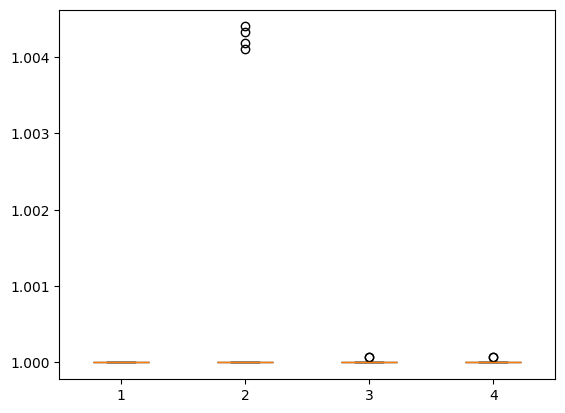

In [9]:
# affichage
rr = []
for rs in rewards:
    rr.append((rewards[0])/rs)
    
plt.boxplot(
        rr,
        patch_artist=True,
        )
plt.show()

In [12]:
print((np.mean(rr, axis=1) - 1)*100)

[0.         0.01702381 0.00014617 0.00014617]


In [6]:
# On regarde ou la DP sous-performe
print(np.where(rr[1]>1))
print(np.where(rr[2]>1))
print(np.where(rr[3]>1))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [4]:
# On cible une instance
instance = 10

In [5]:
# On reessaye la DP
env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                      obs_mode='elimination_gain', 
                      action_mode = 'destinations',
                        change_instance = False, rewards_mode='normalized_terminal', instance_id = instance)
_, info = env.reset()
excess = info['excess_emission']

rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)


# print(env._env.distance_matrix)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, excess)


_, r, *_, info = env.step(a)

print('instance info :')
print(info)

print('la solution calculee à nouveau : ', a +1)
print('reward obtenue par la solution calculee à nouveau : ', r)

print('la solution calculee dans la sim : ', data['res_DP'][instance]['sol'] + 1)
print('reward obtenue par la solution calculee dans la sim : ', rewards[0][instance])


instance info :
{'solution_found': False, 'costs': 145.0, 'time_per_vehicle': array([0., 0., 0., 0.]), 'distance_per_vehicle': array([40., 34., 41., 30.]), 'excess_emission': -0.3000000000000007, 'omitted': array([43, 44, 45])}
la solution calculee à nouveau :  [45 43 44]
reward obtenue par la solution calculee à nouveau :  0.8521212121212122
la solution calculee dans la sim :  [ 1 25 40  9 37  2 23  5 41  8]


NameError: name 'rewards' is not defined

In [9]:
print(rtes)

[[ 0 34 35 36 37 30 28 27 26 25 29  0  0  0  0  0  0]
 [ 0 33 20 21 22 14 10  9  5  4  3  2 13  8 19 18  0]
 [ 0 42 41 47 48 45 49 50 46 44 43 39  0  0  0  0  0]
 [ 0 38 32 40 31 23 15 11  1  7  6 12 16 17 24  0  0]]


In [10]:
env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                    obs_mode='elimination_gain', 
                    action_mode = 'destinations',
                    change_instance = False, rewards_mode='normalized_terminal', instance_id = instance
)
_, info = env.reset()
excess = info['excess_emission']
T_init = 5_000
T_limit = 1
lamb = 0.9999
T = 100_000

action_SA, *_ = recuit(deepcopy(env._env), T_init, T_limit, lamb, H=T)
        # res = recuit_multiple(game, T_init = T_init, T_limit = T_limit, lamb = lamb, log=log, H=T)
a = np.where(action_SA == 0)[0]

# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()

# env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
#                       obs_mode='elimination_gain', 
#                       action_mode = 'destinations',
#                         change_instance = True, rewards_mode='normalized_terminal', instance_id = 89)

env.reset()
_, r, *_, info = env.step(a)
print('la solution calculee à nouveau : ', a + 1)
print('reward obtenue par la solution calculee à nouveau : ', r)

print('la solution calculee dans la sim : ', data['res_SA'][instance]['sol'] +1)
print('reward obtenue par la solution calculee dans la sim : ', rewards[1][instance])

la solution calculee à nouveau :  [40 41 43 44 45 46 47 48 49 50]
reward obtenue par la solution calculee à nouveau :  0.7573333333333333
la solution calculee dans la sim :  [23 40 43 44 45 46 47 48 49 50]
reward obtenue par la solution calculee dans la sim :  0.7573333333333333


In [9]:
from assignment import AssignmentGame

K = 100
with open(f'RL/game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'RL/routes_K{K}.npy')
dests = np.load(f'RL/destinations_K{K}.npy')


# g = AssignmentGame(
#             grid_size=12,
#             max_capacity=1,
#             Q = 7,
#             K=2,
#             emissions_KM = [.1, .3],
#             costs_KM = [1, 1],
#             seed=42
#         )

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                      obs_mode='elimination_gain', 
                      action_mode = 'destinations',
                        change_instance = True, rewards_mode='normalized_terminal', instance_id = 0)
# env = RemoveActionEnv(game = g)
env.reset()

(array([2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 8.33888704e-02,
        2.50000000e-01, 2.50000000e-01, 8.33055648e-05, 0.00000000e+00,
        5.00000000e-01, 5.00000000e-01, 0.00000000e+00, 2.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 8.33888704e-02, 8.33055648e-05,
        2.50000000e-01, 0.00000000e+00, 8.33888704e-02, 2.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000000e-01,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000000e-01,
        8.33055648e-05, 8.33055648e-05, 0.00000000e+00, 2.50000000e-01,
        0.00000000e+00, 2.49916694e-04, 2.50000000e-01, 8.33055648e-05,
        2.50000000e-01, 0.00000000e+00, 8.33888704e-02, 8.33888704e-02,
        8.33055648e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.50000000e-01, 0.00000000e+00, 0.00000000e+00,
        8.33888704e-02, 3.33555482e-01, 0.00000000e+00, 2.50000000e-01,
        2.50000000e-01, 0.00000000e+00, 8.33888704e-02, 2.500000

In [10]:
env.step([])

(array([2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 8.33888704e-02,
        2.50000000e-01, 2.50000000e-01, 8.33055648e-05, 0.00000000e+00,
        5.00000000e-01, 5.00000000e-01, 0.00000000e+00, 2.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 8.33888704e-02, 8.33055648e-05,
        2.50000000e-01, 0.00000000e+00, 8.33888704e-02, 2.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000000e-01,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000000e-01,
        8.33055648e-05, 8.33055648e-05, 0.00000000e+00, 2.50000000e-01,
        0.00000000e+00, 2.49916694e-04, 2.50000000e-01, 8.33055648e-05,
        2.50000000e-01, 0.00000000e+00, 8.33888704e-02, 8.33888704e-02,
        8.33055648e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.50000000e-01, 0.00000000e+00, 0.00000000e+00,
        8.33888704e-02, 3.33555482e-01, 0.00000000e+00, 2.50000000e-01,
        2.50000000e-01, 0.00000000e+00, 8.33888704e-02, 2.500000

In [11]:
print(len(dests))

1000


In [12]:
delete = [l for l in range(len(dests)) if not dests[l].any()]
print(delete)

[]


In [37]:
delete = [l for l in range(len(dests)) if len(dests[l]) != len(set(dests[l]))]
print(delete)

[29, 34, 40]


In [36]:
print(dests[951])

[  0.   3.   6.  17.  19.  20.  21.  27.  28.  30.  32.  35.  45.  47.
  49.  55.  57.  58.  61.  62.  63.  64.  65.  71.  76.  81.  85.  86.
  89.  94.  97.  99. 105. 108. 109. 115. 117. 118. 119. 122. 125. 129.
 130. 131. 132. 134. 136. 140. 142. 143.]


In [32]:
dez = np.delete(dests, delete, 0)

In [33]:
[l for l in range(len(dez)) if not dez[l].any()]

[]

In [10]:
instance = 0
env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                      obs_mode='elimination_gain', 
                      action_mode = 'destinations',
                        change_instance = True, rewards_mode='normalized_terminal', instance_id = instance)
for i in range(instance, 1000):
    *_, info = env.reset()
    aDP, rDP, infoDP = DP(deepcopy(env), info['excess_emission'])
    aSA, rSA, infoSA = SA(deepcopy(env))
    
    if rSA>rDP:
        print(50*'+')
        print(i)
        print('instance info :')
        print(info)
        print('routes : \n', infoDP['rtes'])
        print(10*'-')
        print('la solution DP : ', aDP +1)
        print('reward DP : ', rDP)
        print('info DP : ', infoDP)

        print('la solution SA : ', aSA +1)
        print('reward SA : ', rSA)
        print('info SA : ', infoSA)
        
        print(50*'+')

KeyboardInterrupt: 